# Sales Data Analysis Project

This project analyzes timestamped sales data to uncover trends, detect statistically significant changes, and understand gender and time-of-day purchasing patterns.

### Importing all the libaries

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

### Data Retrieval

This step includes reading all 50 weeks data and merging them.

In [8]:
# Directory containing your files
directory = "./datasets"

# Get a list of all CSV files in the directory
file_list = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]

# Load and concatenate all files
dataframes = [pd.read_csv(file) for file in file_list]
sales_data = pd.concat(dataframes, ignore_index=True)

# Convert 'sale_time' to datetime for analysis
sales_data['sale_time'] = pd.to_datetime(sales_data['sale_time'])

# Display combined dataset info
print(sales_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204329 entries, 0 to 204328
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   sale_time         204329 non-null  datetime64[ns]
 1   purchaser_gender  204329 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.1+ MB
None


### Plotting Daily Sales

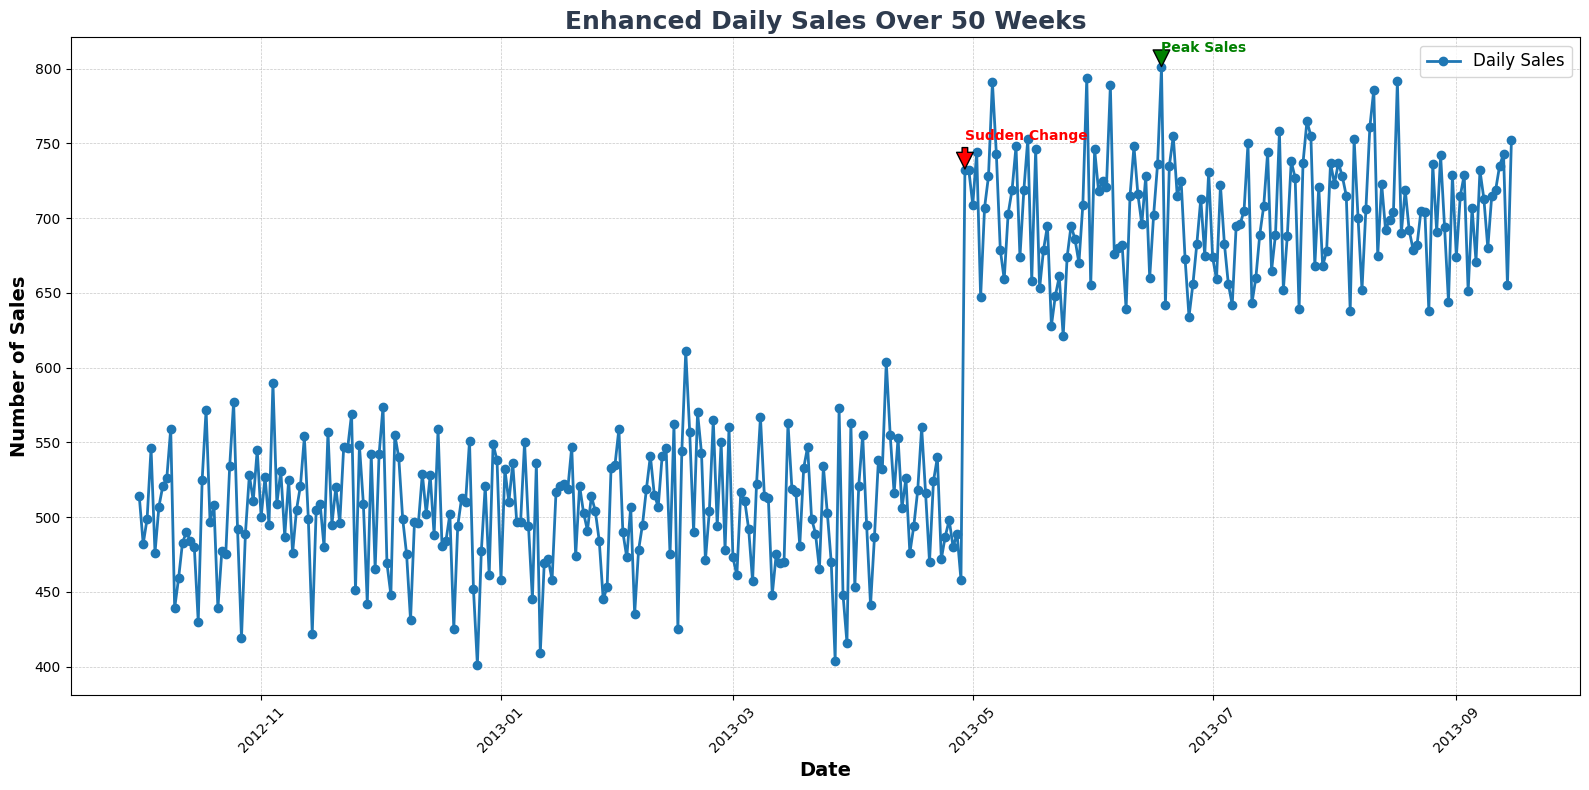

In [9]:

# Group data by date and count sales
daily_sales = sales_data.groupby(sales_data['sale_time'].dt.date).size()

# Identify peak and sudden change
peak_date = daily_sales.idxmax()
sudden_change_date = daily_sales.diff().abs().idxmax()

# Plot with enhanced visuals
plt.style.use('seaborn-v0_8-muted')
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the line chart with styling
ax.plot(daily_sales.index, daily_sales.values, color='#1f77b4', linewidth=2, marker='o', markersize=6, label='Daily Sales')

# Highlight the peak and sudden change with annotations
ax.annotate('Peak Sales', xy=(peak_date, daily_sales.max()), xytext=(peak_date, daily_sales.max() + 10),
            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green', weight='bold')

ax.annotate('Sudden Change', xy=(sudden_change_date, daily_sales[sudden_change_date]),
            xytext=(sudden_change_date, daily_sales[sudden_change_date] + 20),
            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red', weight='bold')

# Add labels, title, and grid
ax.set_title('Enhanced Daily Sales Over 50 Weeks', fontsize=18, fontweight='bold', color='#2E3B4E')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Sales', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add legend
plt.legend(frameon=True, fontsize=12)

# Show the chart
plt.tight_layout()
plt.show()


### Verifying Sudden Change

In [10]:
# Calculate the daily change in sales to identify sudden changes
daily_sales_change = daily_sales.diff().abs()

# Find the date with the maximum change in sales
sudden_change_date = daily_sales_change.idxmax()
sudden_change_value = daily_sales_change.max()

print(f" The sudden change happened on {sudden_change_date} and its value was {sudden_change_value}")

 The sudden change happened on 2013-04-29 and its value was 274.0


### T-Test on daily sales

The two-sample t-test compares the means of two independent groups (before and after the change) to test whether the difference between them is statistically significant.

Null Hypothesis (H₀): There is no difference in the means of daily sales before and after the sudden change date.
<br>Alternative Hypothesis (H₁): There is a significant difference in the means of daily sales before and after the sudden change date.

In [13]:
# Separate data before and after the sudden change date
before_change = daily_sales[daily_sales.index < sudden_change_date]
after_change = daily_sales[daily_sales.index >= sudden_change_date]

# Perform a t-test to determine statistical significance
t_stat, p_value = ttest_ind(before_change, after_change, equal_var=False)

print(f't-statistic: {t_stat}\n')
print(f'p_value: {p_value}')

t-statistic: -45.943533193935615

p_value: 3.487246853115062e-138


#### t-statistic (-45.94):
> The negative value indicates that the mean of the "before" group is significantly lower than the mean of the "after" group.
> The large magnitude (absolute value) of the t-statistic suggests a very strong difference between the two groups.

#### p-value (3.487e-138):
> The p-value is extremely small (almost zero).
> Since it is far smaller than the common significance level (e.g., 0.05), we reject the null hypothesis.

#### Conclusion:
The results show that the change in daily sales is statistically significant. The likelihood that this difference occurred by random chance is extremely low.

### Analyzing if shift is due to a change in proportion of male-female customers

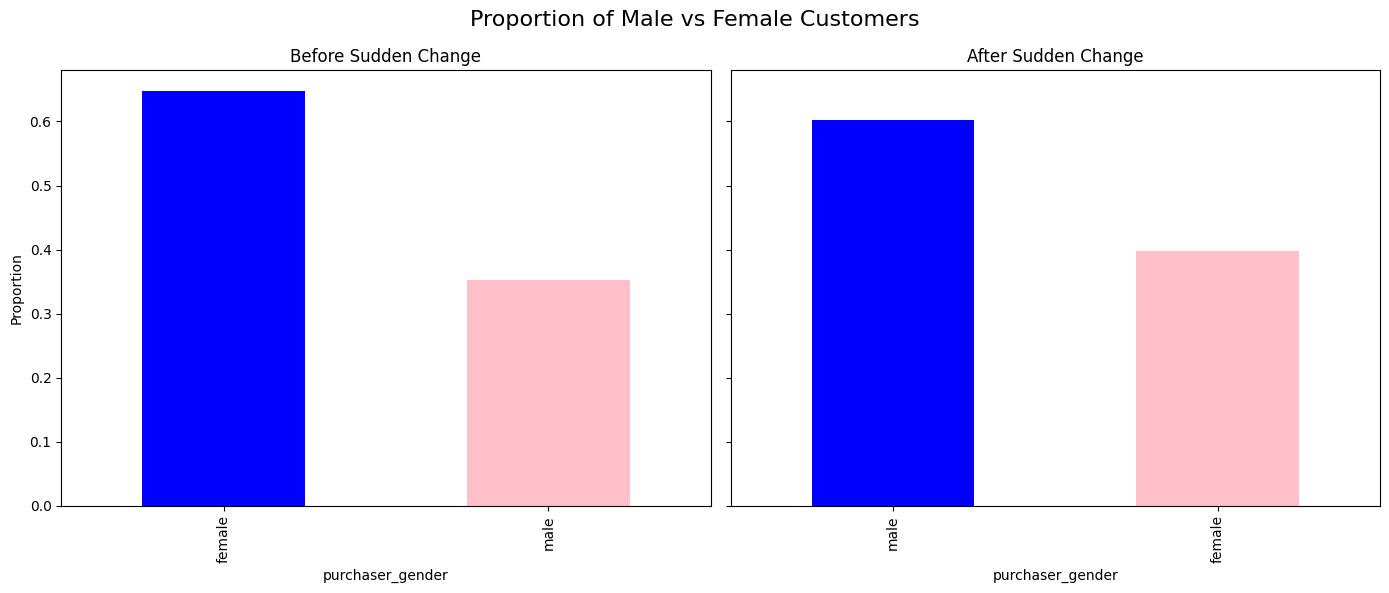

 Gender proportion before sudden change -> 
 Female: 0.65 
 Male: 0.35


 Gender proportion after sudden change -> 
 Female: 0.60 
 Male: 0.40


In [19]:
# Calculate the proportion of male and female customers before and after the sudden change date
gender_proportion_before = sales_data[sales_data['sale_time'].dt.date < sudden_change_date]['purchaser_gender'].value_counts(normalize=True)
gender_proportion_after = sales_data[sales_data['sale_time'].dt.date >= sudden_change_date]['purchaser_gender'].value_counts(normalize=True)

# Plot gender proportions
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

gender_proportion_before.plot(kind='bar', ax=ax[0], color=['blue', 'pink'], title='Before Sudden Change', ylabel='Proportion')
gender_proportion_after.plot(kind='bar', ax=ax[1], color=['blue', 'pink'], title='After Sudden Change', ylabel='Proportion')

plt.suptitle('Proportion of Male vs Female Customers', fontsize=16)
plt.tight_layout()
plt.show()

print(f' Gender proportion before sudden change -> \n Female: {gender_proportion_before.iloc[0]:.2f} \n Male: {gender_proportion_before.iloc[1]:.2f}\n\n')
print(f' Gender proportion after sudden change -> \n Female: {gender_proportion_after.iloc[0]:.2f} \n Male: {gender_proportion_after.iloc[1]:.2f}')

Although the proportion of male customers increased, this shift is relatively small and does not strongly suggest that the change in sales is entirely due to a shift in customer gender distribution.

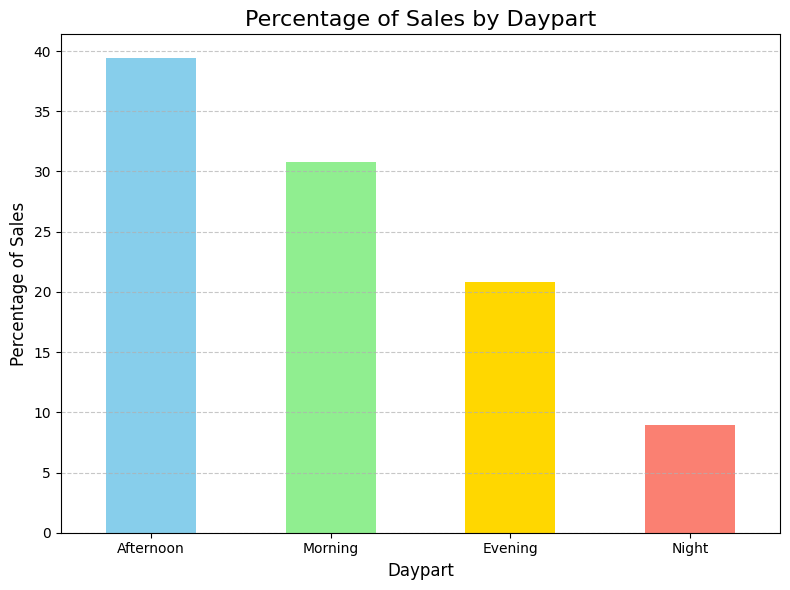

daypart
Afternoon    39.413397
Morning      30.769005
Evening      20.858517
Night         8.959081
Name: proportion, dtype: float64

In [11]:
# Define dayparts
def get_daypart(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Assign dayparts based on the sale_time
sales_data['daypart'] = sales_data['sale_time'].dt.hour.map(get_daypart)

# Calculate the percentage of sales in each daypart
daypart_percentage = sales_data['daypart'].value_counts(normalize=True) * 100

# Plot daypart percentages
plt.figure(figsize=(8, 6))
daypart_percentage.plot(kind='bar', color=['skyblue', 'lightgreen', 'gold', 'salmon'])
plt.title('Percentage of Sales by Daypart', fontsize=16)
plt.xlabel('Daypart', fontsize=12)
plt.ylabel('Percentage of Sales', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

daypart_percentage
